In [25]:
import itertools
from copy import deepcopy as copy
from scipy.linalg import fractional_matrix_power, block_diag
import networkx as nx
import cvxpy as cp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy 
from numpy.linalg import matrix_rank as rank 
from Adversary import Problem, to_str, visualize, Adversary, hamming_dist as dist
from Solvers import type_mask, partial, ket, instance_mask, adv_solver
from ElementDistinctness import ED
from Examples import exact_k, threshold_k
from time import time
mpl.rcParams["figure.dpi"] = 270

In [64]:
def get_phase_oracles(problem):
    oracles = {}
    n = problem.n
    # roots = nthRootsOfUnity(n)
    for instance in problem.instances:
        oracle = np.zeros((n,n))
        for i in range(n):
            oracle[i, i] =-1 if instance[i] == 1 else 1
        oracles[instance] = oracle
        
    return oracles

def get_standard_oracles(problem):
    oracles = {}
    n = problem.n
    alpha_len = len(problem.alphabet)
    for instance in problem.instances:
        oracle = []
        for i in range(n):
            curr_oracle = np.zeros((alpha_len, alpha_len))
            for a in problem.alphabet:
                curr_oracle[a, (instance[i] + a) % alpha_len] = 1
            # print(curr_oracle)
            oracle.append(copy(curr_oracle))
        oracles[instance] = block_diag(*oracle)
        # print(oracles[instance])
    return oracles

def get_oracle_diffs(oracles, prod=True):
    oracle_diffs = {} 
    for v1 in oracles:
        for v2 in oracles:
            if prod:
                oracle_diffs[(v1, v2)] = np.eye(oracles[v1].shape[0])- oracles[v1].T @ oracles[v2]
            else:
                # print('normal diff')
                oracle_diffs[(v1, v2)] = oracles[v1] - oracles[v2]
    return oracle_diffs
    
def get_permutation_oracles(problem):
    # assuming instances are all lists representing permutations
    oracles = {}
    n = problem.n
    assert tuple(range(n)) == problem.alphabet
    for instance in problem.instances:
        oracle = np.zeros((n, n))
        for i in range(n):
            oracle[i, instance[i]] = 1
        oracles[instance] = oracle
        # assert oracle@oracle.T - np.eye(n)
    return oracles

def preimage_even_odd(n):
    perms = itertools.permutations(range(n))
    no_instances = []
    yes_instances = []
    for perm in get_cycles(n,n):
        # print(to_str(perm))
        if perm.index(0) >= n//2:
            yes_instances.append(perm)
        else:
            no_instances.append(perm)
    return Problem(no_instances, yes_instances)

In [57]:
def get_cycles(n, k):
    perm = tuple(range(n))
    yes_instances = set()
    for cycle_points in itertools.permutations(perm, k):
        curr_cycle = list(perm)
        for i in range(k-1):
            curr_cycle[cycle_points[i]] = cycle_points[i+1]
        curr_cycle[cycle_points[-1]] = cycle_points[0]
        yes_instances.add(tuple(curr_cycle))
    return list(yes_instances)
def num_fixed_points(perm):
    curr_sum = 0
    for i in range(len(perm)):
        if perm[i] == i:
            curr_sum += 1
    return curr_sum

def permutation_thresh(n, k):
    # perm = nkp.array(range(n))
    no_instances = set()
    yes_instances = set()
    for perm in itertools.permutations(tuple(range(n))):
        num_fixed = num_fixed_points(perm)
        if num_fixed == k:
            no_instances.add(perm)
        elif num_fixed == k + 1:
            yes_instances.add(perm)
    return Problem(list(no_instances), list(yes_instances))
def equality(n):
    perms = list(itertools.permutations(list(range(n))))
    no_instances = []
    yes_instances = [tuple(perm + tuple(p + n for p in perm)) for perm in perms]
    for perm1, perm2 in itertools.combinations_with_replacement(perms, 2):
        instance = tuple(perm1+ tuple(p + n for p in perm2))
        if dist(perm1, perm2) == 2:
            no_instances.append(instance)
    return Problem(no_instances, yes_instances)


def fixed_points(n, k):
    no_instances = []
    yes_instances = []
    for perm in itertools.permutations(range(n)):
        fp = num_fixed_points(perm)
        if fp == k:
            no_instances.append(perm)
        elif fp == k+1:
            yes_instances.append(perm)
    return Problem(no_instances, yes_instances)
        
def cycle0(n, k):
    no_instances = [cycle for cycle in get_cycles(n, k) if cycle[0] != 0]
    yes_instances = [cycle for cycle in get_cycles(n, k+1) if cycle[0] != 0]
    return Problem(no_instances, yes_instances)
def cycle(n, k, k2=None):
    if k2 is None:
        k2 = k+1
    no_instances = get_cycles(n,k)
    yes_instances = get_cycles(n, k2)
    return Problem(no_instances, yes_instances)

def preimage(n, k):
    # perms = list(itertools.permutations(range(n)))
    no_instances = []
    yes_instances = []
    for perm in get_cycles(n, k):
        preimage0 = perm.index(0)
        # print(preimage0, perm)
        if preimage0 % 2:
            yes_instances.append(perm)
        else:
            no_instances.append(perm)
    # print(no_instances)
    # print(yes_instances)
    return Problem(no_instances, yes_instances)
def get_all_cycles(perm):
    cycles =[]
    points_in_cycles = set()
    for i in range(n):
        if i not in points_in_cycles and perm[i] != i:
            cycle = [i]
            j = perm[i]
            points_in_cycles.add(j)
            while j not in cycle:
                cycle.append(j)
                j = perm[j]
                points_in_cycles.add(j)
            cycles.append(tuple(cycle))
    return cycles

def num_cycles(perm):
    return len(get_all_cycles(perm))
        
def transpose_thresh(n, k):
    perms = itertools.permutations(range(n))
    no_instances = []
    yes_instances = []
    for perm in perms:
        cycles = get_all_cycles(perm)
        cycle_lengths = set(len(cycle)  for cycle in cycles)
        if cycle_lengths == set([2]):
            if len(cycles) == k:
                no_instances.append(perm)
            elif len(cycles) == k+1:
                yes_instances.append(perm)
    return Problem(no_instances, yes_instances)

def transpose(n, easy=False):
    perm = tuple(range(n))
    no_instances = []
    if easy:
        for i in range(n//2):
            instance = list(perm)
            instance[2*i] = 2*i + 1
            instance[2*i+1] = 2*i
            no_instances.append(tuple(instance))
    else:
        for i,j in itertools.combinations(perm, 2):
            # print(i,j)
            instance = list(perm)
            instance[i] = j
            instance[j] = i
            no_instances.append(tuple(instance))
    return Problem([perm], list(no_instances))

def relative_hadamard_norm_min(mat, relative, D1_len):
 
    mat_len = mat.shape[0]
    mat_size = mat_len
    D1 = list(range(D1_len))
    D2 = list(range(D1_len, mat_size))
    relative_shape = relative[0][0].shape
    t = cp.Variable(nonneg=True)
    X = [[cp.Variable(relative_shape) for _ in range(mat_len)] for _ in range(mat_len)]
    for x in D1:
        for y in D2:
            X[x][y] = cp.Variable(relative_shape)
    constraints = [cp.bmat(X) >> 0]
    constraints += [
        mat[x][y] == cp.trace(X[x][y].T @ relative[x][y]) 
        for x in range(mat_size) for y in range(mat_size)
    ]
    constraints += [
        t >= cp.trace(X[z][z]) for z in range(mat_size)
    ]
    
    opt_prob = cp.Problem(cp.Minimize(t), constraints)
    opt_prob.solve(verbose=True) 
    for x in range(mat_size):
        for y in range(mat_size):
            X[x][y] = X[x][y].value
    return X
    
def relative_hadamard_norm_max(mat, relative, D1_len, solver="MOSEK"):

    relative_shape = relative[0][0].shape
    D1 = list(range(mat.shape[0]))
    D2 = list(range((mat.shape[1]))) 
    
    # print(D1_len, len(D2), relative.shape)
    relative_mat = np.block(relative)
    print(relative_mat.shape)
    mu = cp.Variable((len(D1)+len(D2)), nonneg=True)
    Lambda = cp.Variable((len(D1), len(D2)))
    Lambda_relative = cp.kron(Lambda, np.ones(relative_shape))
    Lambda_relative = cp.multiply(Lambda_relative, relative_mat)
    Lambda_square_relative = cp.bmat([
        [np.zeros((Lambda_relative.shape[0], Lambda_relative.shape[0])), Lambda_relative
        ],
        [Lambda_relative.T, np.zeros((Lambda_relative.shape[1], Lambda_relative.shape[1]))]
    ])
    
    diag = cp.kron(cp.diag(mu), np.eye(relative_shape[0]))
    # print(W.shape, diag.shape)
    W = Lambda_square_relative + diag
    # print(W)
    constraints = [cp.sum(mu) == 1, W >> 0]
    opt_prob = cp.Problem(cp.Maximize(2 * cp.trace(Lambda.T@mat)), constraints)
    opt_prob.solve(verbose=True, solver=solver, mosek_params= {"MSK_IPAR_NUM_THREADS": 8}) 
    return Lambda.value, mu.value

def to_adversary_mat(Lambda, mu):
    G = np.zeros(Lambda.shape)
    for x in range(Lambda.shape[0]):
        for y in range(Lambda.shape[1]):
            G[x,y] = Lambda[x,y]/(mu[x] * mu[Lambda.shape[0] + y])
            
    return G

In [58]:
# get_all_cycles([0,3,4,2,1])

80
cap set()
(120, 360)
                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) May 23 05:17:02 PM: Your problem has 1280 variables, 2 constraints, and 0 parameters.
(CVXPY) May 23 05:17:02 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 23 05:17:02 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 23 05:17:02 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) May 23 05:17:02 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 23 05:17:02 PM: Compiling problem 

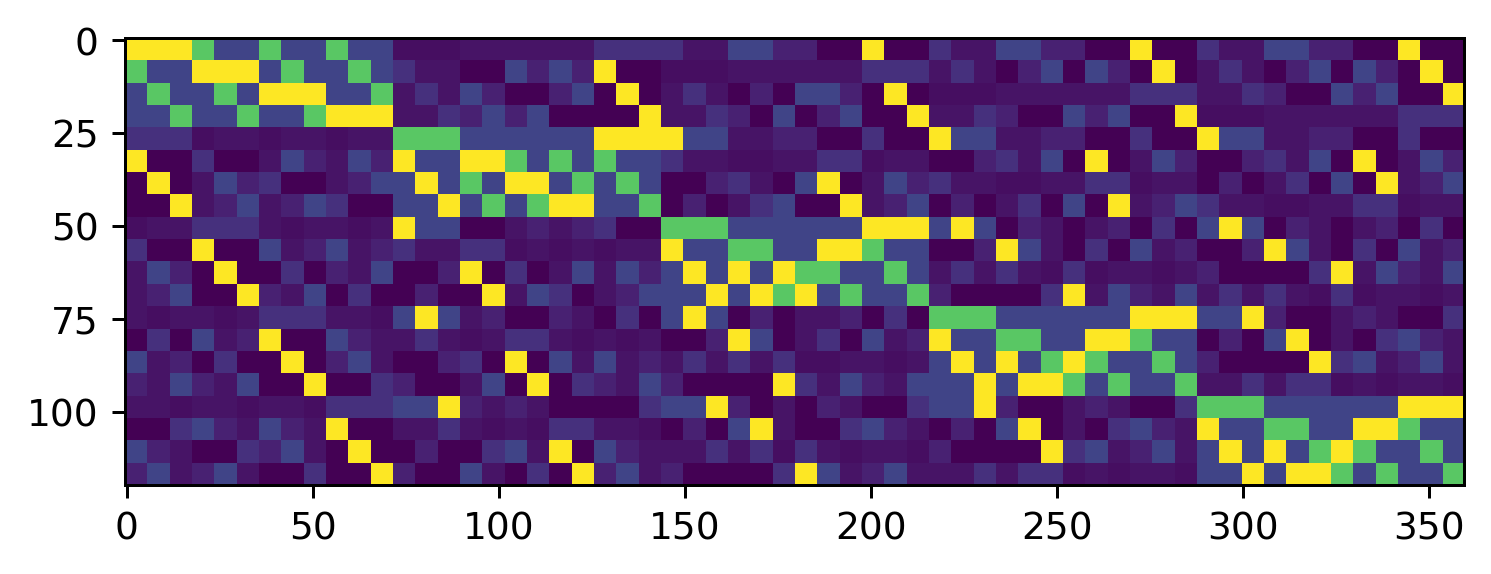

In [69]:
n = 6
k =3
prob = cycle0(n, k)
print(prob.len)
print('cap', set(prob.no_instances).intersection(set(prob.yes_instances)))
oracles = get_permutation_oracles(prob)
oracle_diffs_dict = get_oracle_diffs(oracles, prod=False)
oracle_diffs = [[
    oracle_diffs_dict[(prob.no_instances[i], prob.yes_instances[j])] for j in range(len(prob.yes_instances))]
    for i in range(len(prob.no_instances))
] 
# print(oracle_diffs[0][1])
# print(np.linalg.matrix_rank(oracle_diffs[0][1]))
# print('boop')
# print(oracles[prob.instances[0]])
# plt.imshow(np.block(oracle_diffs))
# plt.show()
# plt.imshow(oracles[prob.no_instances[3]])
# plt.show()

# plt.imshow(oracles[prob.instances[1]])
# plt.show()

# plt.imshow(oracles[prob.no_instances[0]].T-oracles[prob.yes_instances[1]])
# plt.show()

mat = np.ones((prob.no_len, prob.yes_len))
start = time()
Lambda, mu = relative_hadamard_norm_max(mat, (oracle_diffs), prob.no_len, solver="MOSEK")
plt.imshow(np.kron(Lambda, np.ones((n,n))))
print("time",  time()-start)

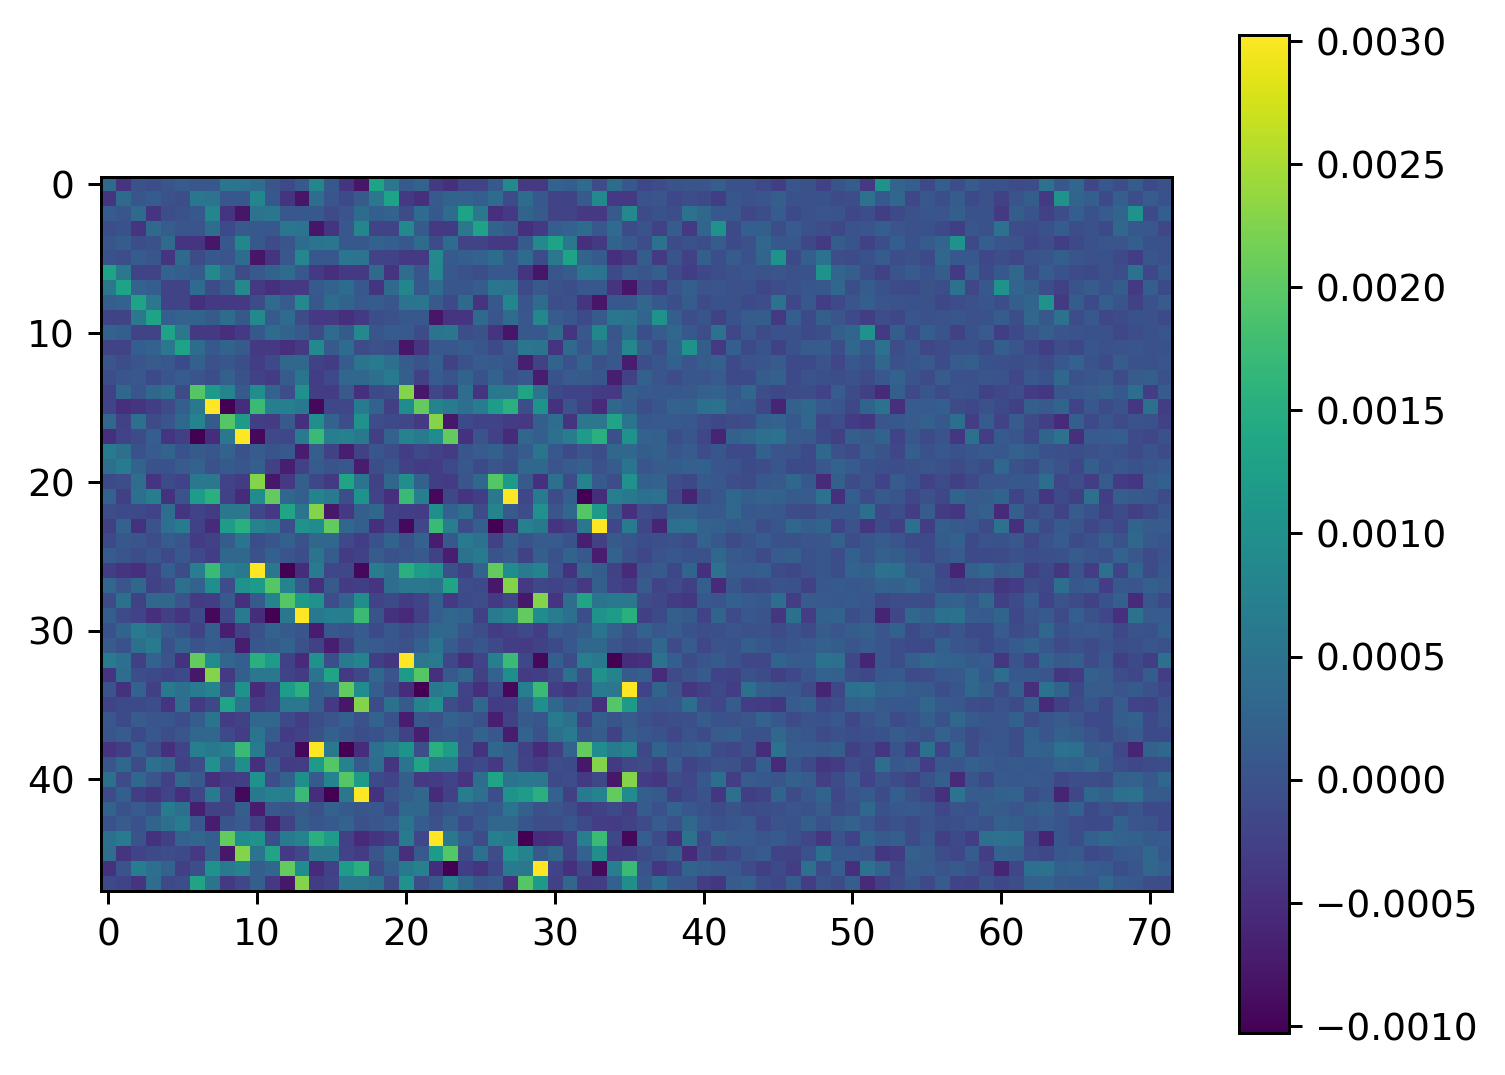

-0.0010276324025420731


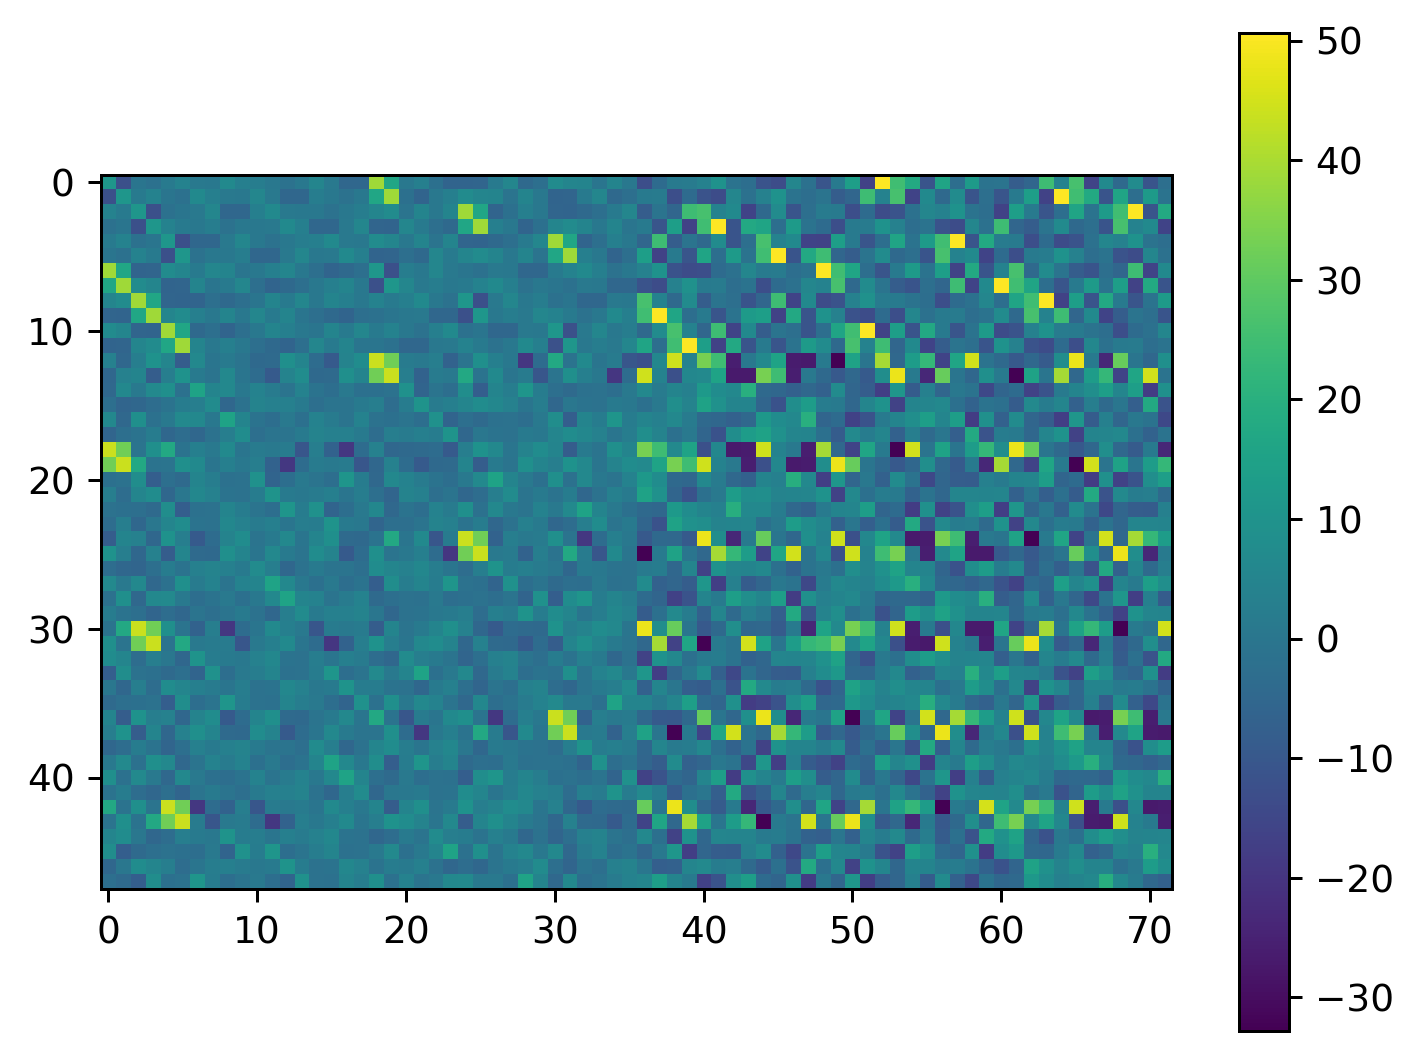

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) May 23 05:15:16 PM: Your problem has 14520 variables, 9 constraints, and 0 parameters.
(CVXPY) May 23 05:15:16 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 23 05:15:16 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 23 05:15:16 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) May 23 05:15:16 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 23 05:15:16 PM: Compiling problem (target solver=MOSEK).


In [65]:
def to_str(L):
    return ''.join([str(x) for x in L])
    
def to_str_list(L):
    return [to_str(x) for x in L]

def visualize(mat, labels=None, to_string=False, save=None):
    fig, ax = plt.subplots()
    heatmap = ax.imshow(mat)
    plt.tight_layout()
    figh, figw = fig.get_size_inches()
    font_sizey = figh * 72  / 3 
    font_sizey = font_sizey / np.max(mat.shape)
    font_sizex = figw * 72  / 3 / np.mat(mat.shape)
    
    # fig.set_size_inches(mat., mat.shape[1]/5)
    plt.colorbar(heatmap)
    if labels is not None:
        # print(here)
        fig.subplots_adjust(bottom=0.25, left=0.25)
        xlabels, ylabels = labels
        print(xlabels, ylabels)
        if to_string:
            ylabels = to_str_list(ylabels)
            xlabels = to_str_list(xlabels)

            # print(xlabels)
            # print('blah', ylabels, to_str_list(ylabels))
        print(mat.shape)
        ax.set_xticks(np.arange(mat.shape[1]), minor=False)
        ax.set_yticks(np.arange(mat.shape[0]), minor=False)
        print(len(xlabels))
        ax.set_xticklabels(xlabels, rotation=90, fontsize=font_sizey)
        ax.set_yticklabels(ylabels, fontsize=font_sizey)
    if save is not None:
        plt.savefig(save)
    else:
        plt.show() 
        
plt.imshow(Lambda)
plt.colorbar()
plt.show()
print(np.min(Lambda))
# print(len(set(prob.yes_instances)))
# print(prob.yes_instances)
# print(Lambda.shape)

# print(2*np.sum(Lambda))
# print(Lambda[0,1])
G = to_adversary_mat(Lambda, mu)
plt.imshow(G)
plt.colorbar()
plt.show()
# print(Lambda.shape)
A,_ = adv_solver(prob)

['130452', '130524', '140253', '140532', '150234', '150423', '203451', '203514', '204153', '204531', '205134', '205413', '301452', '301524', '304251', '304512', '305214', '305421', '320451', '320514', '340152', '340521', '350124', '350412', '401253', '401532', '403152', '403521', '405123', '405231', '420153', '420531', '430251', '430512', '450132', '450213', '501234', '501423', '503124', '503412', '504132', '504213', '520134', '520413', '530214', '530421', '540123', '540231']
['123450', '123504', '124053', '124530', '125034', '125403', '134250', '134502', '135204', '135420', '143052', '143520', '145023', '145230', '153024', '153402', '154032', '154203', '231450', '231504', '234051', '234510', '235014', '235401', '241053', '241530', '243150', '243501', '245031', '245103', '251034', '251403', '253104', '253410', '254013', '254130', '324150', '324501', '325104', '325410', '341250', '341502', '345120', '345201', '351204', '351420', '354102', '354210', '423051', '423510', '425013', '425130'

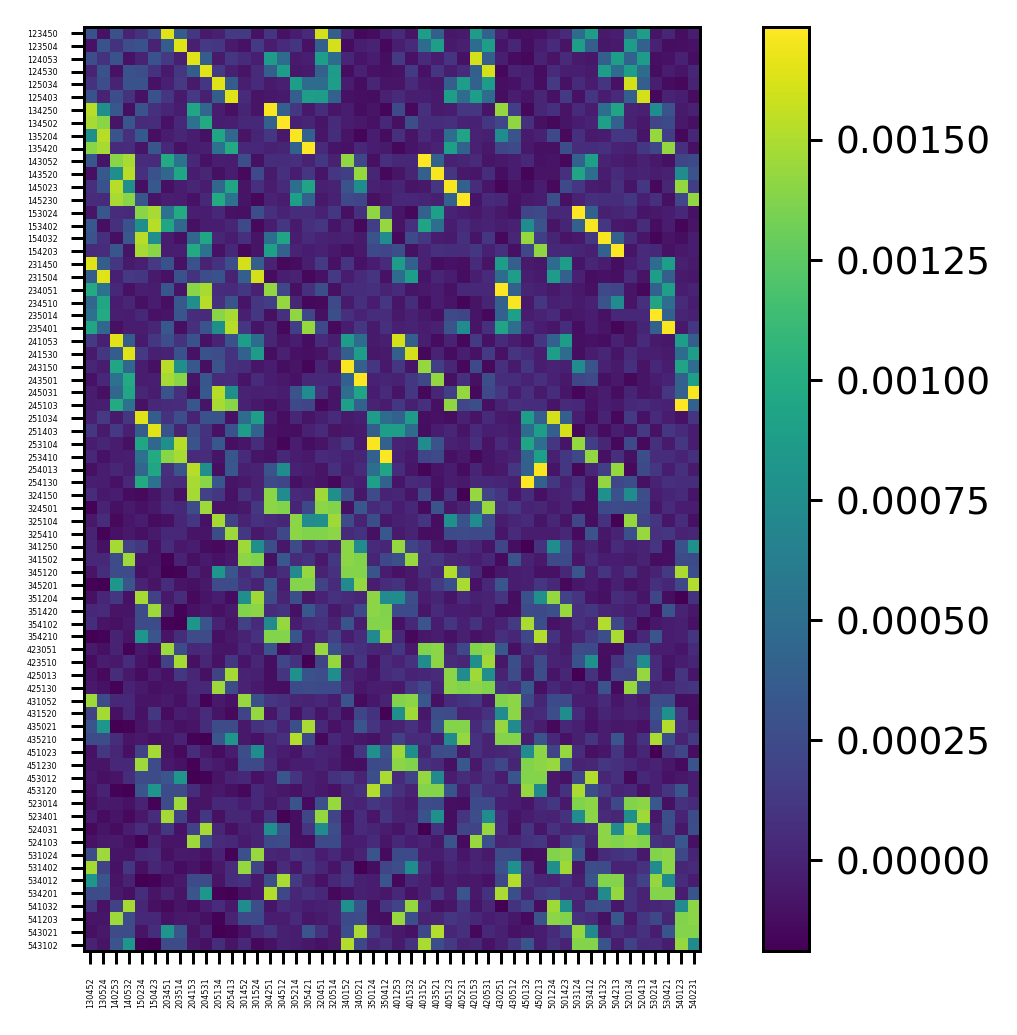

{0.0, -9.85e-05, 0.0008184, 7.6e-06, 0.0002122, -9.09e-05, 0.0014322, -0.0001894, 1.52e-05, -8.33e-05, 0.0014398, 2.28e-05, 3.04e-05, 0.000235, 3.8e-05, 0.0002426, 0.0004472, -6.05e-05, 0.0002502, -0.0001514, 5.32e-05, 0.0013793, 0.0003791, -2.25e-05, -0.000121, 8.36e-05, -1.49e-05, 0.0002958, -0.0001058, 9.88e-05, 3e-07, 0.0008187, 0.0002125, 0.0014325, -9.06e-05, 1.55e-05, 0.0014401, 2.31e-05, -7.54e-05, 3.07e-05, 0.000743, 3.83e-05, 0.0002429, -6.02e-05, 4.59e-05, -4.5e-05, -3.74e-05, 0.0014933, -0.0001283, 0.0013948, -2.22e-05, 8.39e-05, 9.15e-05, 0.0002961, -7e-06, -0.0001055, 9.91e-05, 0.0004098, 0.000819, 8.2e-06, -9.03e-05, 0.0014404, 2.34e-05, -7.51e-05, 0.0009403, 3.1e-05, 0.0007433, -6.75e-05, 3.86e-05, 4.62e-05, -4.47e-05, -3.71e-05, -0.000128, -2.19e-05, 0.0014027, 0.0017134, -6.7e-06, -0.0001052, 0.0004101, -9.76e-05, 0.0008193, 8.5e-06, 1.61e-05, -8.24e-05, 0.0009406, -5.2e-05, 6.17e-05, 0.0002739, -2.92e-05, 0.0008953, 0.001403, 0.0017137, -6.4e-06, -0.0001049, 0.000410

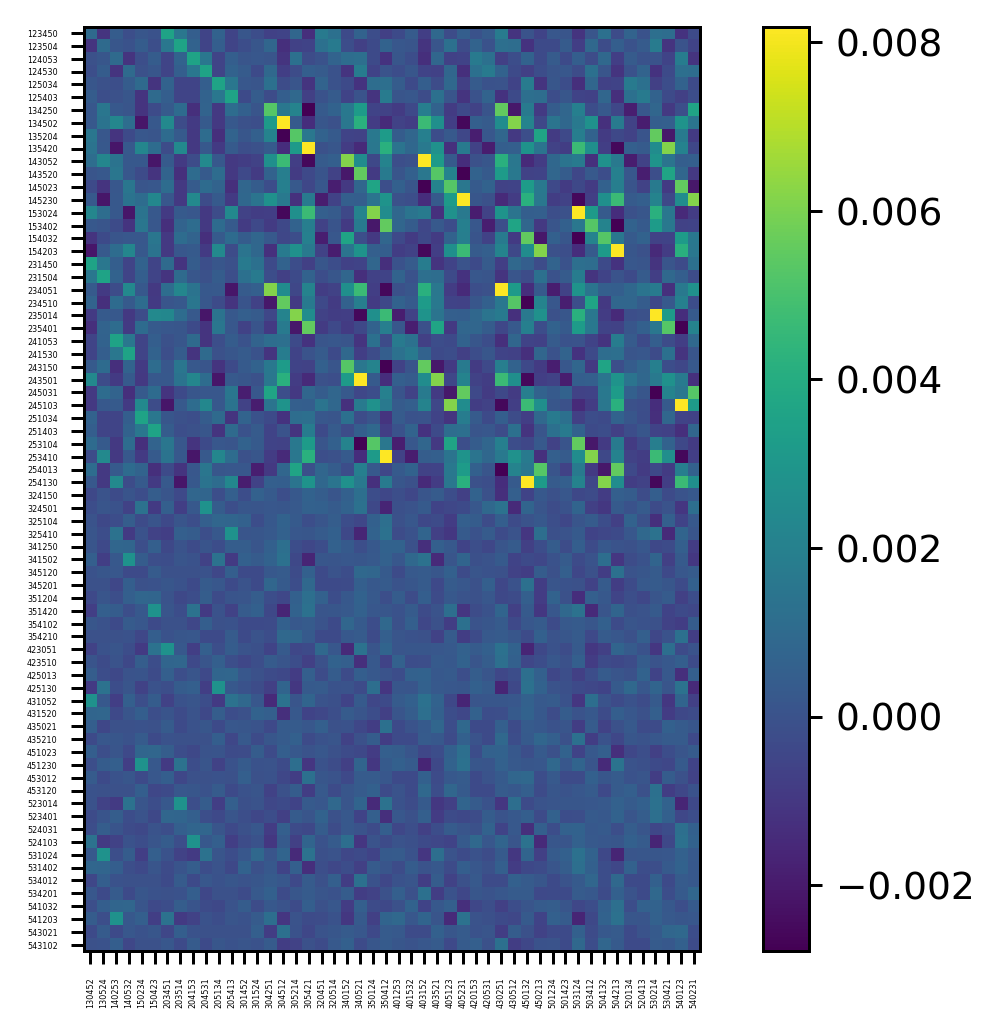


{1.52e-05, 0.0001213, 0.0013413, -0.0004849, 0.0002274, 0.0006366, 0.0001289, 0.0008412, 3.04e-05, -0.0002727, 0.0019627, -0.0001666, 0.0001441, -0.000159, 4.56e-05, -5.29e-05, -0.0001514, 5.32e-05, 0.00047, 0.000273, 0.0007807, 0.0001821, 0.0030237, -1.49e-05, 0.0001973, 0.000705, 1.55e-05, -7.54e-05, 0.00094, 0.0001292, 0.0008415, 3.07e-05, 0.0010461, -0.0002724, 0.0002429, -0.0001587, 4.59e-05, 0.0002505, -0.0001511, 0.0005612, 0.0004627, -3.74e-05, 0.0004703, 0.0001824, -1.46e-05, 9.15e-05, -0.0004162, 0.0001976, -0.000204, -9.79e-05, 0.0001143, 0.0005235, 0.0001219, 0.0020542, -7.51e-05, 0.0001295, 0.0006372, -0.0006813, -0.0002721, 0.0001371, -0.000166, 0.0002508, -0.0007646, 0.0002584, 0.000463, -0.0005448, 6.9e-05, 0.0007813, 0.0003873, -1.43e-05, -0.0001128, -0.0004159, 9.94e-05, 0.0005238, 0.0002207, 0.0007284, -8.24e-05, 0.0013422, 0.0005314, -7.48e-05, 0.0001298, -0.000681, -0.0002718, 0.0002435, 4.65e-05, 0.0002511, -0.0007643, 0.0004633, -0.0002414, 0.0008801, 0.0007816,

In [66]:
A.visualize_matrix()
print(set(np.round(A.matrix.flatten(), 7)))
visualize(Lambda.T/np.sum(Lambda), ( prob.no_instances, prob.yes_instances), to_string=True)
print()
print(set(list(np.round(Lambda.flatten(), 7))))
print(np.min(Lambda))
print(Lambda)

In [24]:
print(G[0,1])

5.184971863939131


In [9]:
def phase_feasibility(problem, t, W):
    oracles = get_phase_oracles(problem)
    A = cp.Variable((2**W, 2**W), hermitian=True)
    cp.

SyntaxError: invalid syntax (1324326215.py, line 4)